## IImport libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

import torch
import torchvision
import torchvision.transforms as transforms
import torch
cuda = torch.cuda.is_available()

try:
    from plotting_CIFAR10 import plot_autoencoder_stats
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

## Image noise function


In [2]:
add_noise = True

def add_noise_and_clip_data(MM):
    data = MM
    noise = np.random.normal(loc=0.0, scale=0.3, size=data[0].shape)
    for i in range(len(data[:])):
        data[i] = data[i] + noise
        data[i] = np.clip(data[i], -1., 1.)
    return data

def gaussian_noise(data):
    noise = np.random.normal(loc=0.0, scale=0.3, size=data.shape)
    data = data + noise
    data = np.clip(data, -1., 1.)
    return data

def salt_and_pepper_noise(data,prob_salt,prob_peper):
    noise_pepper = np.random.choice([0,1],size=(data.shape[1],data.shape[2]),p=[prob_peper,1.-prob_peper])
    noise_salt = np.random.choice([0,1],size=(data.shape[1],data.shape[2]),p=[prob_salt,1.-prob_salt])
    #Salt = np.multiply(noise,(-1.)*np.ones((data.shape[1],data.shape[2])))
    P = np.zeros(data.shape)
    P[0][:][:] = noise_pepper
    P[1][:][:] = noise_pepper
    P[2][:][:] = noise_pepper
    data = np.multiply(data,P)
    data = data + (np.ones(data.shape)-P)*(-1)
    P[0][:][:] = noise_salt
    P[1][:][:] = noise_salt
    P[2][:][:] = noise_salt
    data = np.multiply(data,P)
    data = data + (np.ones(data.shape)-P)
    return data

def overexposure(data,value):
    data = data + value*np.ones(data.shape)
    data = np.clip(data, -1., 1.)
    return data

def underexposure(data,value):
    data = data - value*np.ones(data.shape)
    data = np.clip(data, -1., 1.)
    return data
    

# Not all images have added noise
def add_noise_to_images(data,prob_gaussian_noise,prob_sp_noise,prob_overexposure,prob_underexposure):
    for i in range(len(data)):
        if (random.uniform(0,1) < prob_gaussian_noise):
            data[i] = gaussian_noise(data[i])
        elif (random.uniform(0,1) < prob_sp_noise):
            data[i] = salt_and_pepper_noise(data[i],0.1,0.1)
        elif (random.uniform(0,1) < prob_underexposure):
            data[i] = underexposure(data[i],random.uniform(0,1)/2 + 0.5)
        elif (random.uniform(0,1) < prob_overexposure):
            data[i] = overexposure(data[i],random.uniform(0,1)/2 + 0.5)
    return data

## Import Data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#if (add_noise):
#    Noisy_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                            download=True, transform=transform)
#    Noisy_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                           download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    
    # Noisy training and test data
    #if (add_noise):
    #    new_noisy_train_data = []
    #    new_noisy_train_labels = []
    #    new_noisy_test_data = []
    #    new_nosiy_test_labels = []
    
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]
        
        # Noisy train and test data
        #if (add_noise):
        #    new_noisy_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        #    new_noisy_train_labels += [i for _ in range(new_noisy_train_data[-1].shape[0])]

        #    new_noisy_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        #    new_nosiy_test_labels += [i for _ in range(new_noisy_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels
    
    # Noisy train and test data
    #if (add_noise):
    #    new_noisy_train_data = np.concatenate(new_noisy_train_data, 0)
    #    Noisy_trainset.data = new_noisy_train_data
    #    Noisy_trainset.targets = new_noisy_train_labels
    #    new_noisy_test_data = np.concatenate(new_noisy_test_data, 0)
    #    Noisy_testset.data = new_noisy_test_data
    #    Noisy_testset.targets = new_nosiy_test_labels

# Batch size is set to 64 
batch_size = 64

torch.manual_seed(0)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#torch.manual_seed(0)

#Noisy_trainloader = torch.utils.data.DataLoader(Noisy_trainset, batch_size=batch_size,
#                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

train_data_iter = iter(trainloader)

test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [4]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 50000
Batch dimension [B x C x H x W]: torch.Size([64, 3, 32, 32])
Number of distinct labels: 10

# Test data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([64, 3, 32, 32])
Number of distinct labels: 10


 deer   cat truck plane


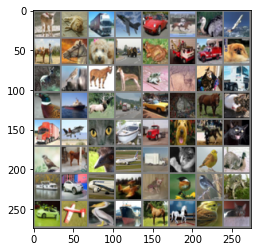

In [5]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2. + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))
#print(images)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Display noise functions on images

64
torch.Size([3, 32, 32])
 deer   cat truck plane


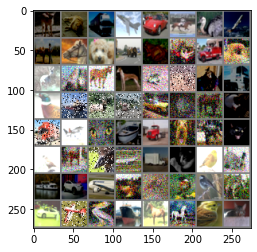

In [6]:
print(len(images[:]))
print(images[0].shape)
#print(images[0])
MM = copy.deepcopy(images)
MM = add_noise_to_images(MM,0.25,0.25,0.5,0.5)
# show images
imshow(torchvision.utils.make_grid(MM))
#print(images)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Original Image

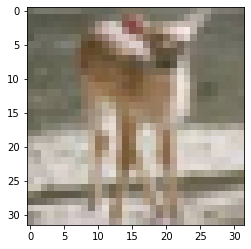

In [7]:
imshow(images[0])

### Image with Gaussian noise

Image with Gaussian noise


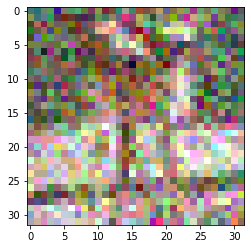

In [8]:
print("Image with Gaussian noise")
imshow(gaussian_noise(images[0]))

### Image with underexposure

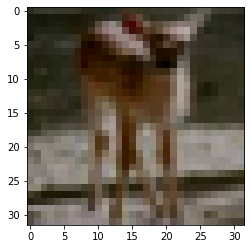

In [9]:
imshow(underexposure(images[0],0.5))

### Image with overexposure

Image with overexposure


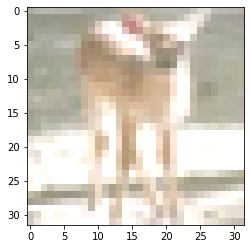

In [10]:
print("Image with overexposure")
imshow(overexposure(images[0],0.5))

### Image with Salt and Pepper noise

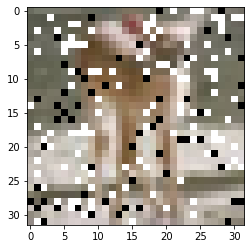

In [11]:
imshow(salt_and_pepper_noise(images[0],0.1,0.05))

 deer   cat truck plane


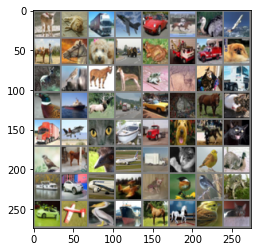

In [12]:
# Used in order to check that the images variable has not been overwritten
imshow(torchvision.utils.make_grid(images))
#print(images)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

## Network Structure

In [14]:
# Image dimensions
channels = x.shape[1]
height = x.shape[2]
width = x.shape[3]
num_features = (height * width) * channels

def compute_conv_dim(dim_size,kernel_size,padding_size,stride_size):
    return int((dim_size - kernel_size + 2 * padding_size) / stride_size + 1)

# First convolution layer
num_filters_conv1 = 16
kernel_size_conv1 = 5 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1 = 2
input_dim = 32

# Second convolution layer
num_filters_conv2 = 5
kernel_size_conv2 = 5
stride_conv2 = 1
padding_conv2 = 1

# Convolutional layers
filters = [32,64,128,256,256]
kernels = [3,3,3,3,3]
padding = [1,1,1,1,1]
strides = [2,2,2,2,1]

# Hidden nodes in linear layers in Encoder
h1e = 2000
h2e = 1875

# Hidden nodes in linear layers in Decoder 
h1d = 2352
h2d = 1000

class AutoEncoder(nn.Module):
    def __init__(self, latent_features=2):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.
        
        ############################
        # Encoder (downsampling)   #
        ############################
        self.enc_conv0 = Conv2d(3, 32, 3, stride=2, padding=1)
        #self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_norm0 = nn.BatchNorm2d(32)
        self.enc_conv1 = Conv2d(32, 64, 3, stride=2, padding=1)
        #self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_norm1 = nn.BatchNorm2d(64)
        self.enc_conv2 = Conv2d(64, 128, 3, stride=2, padding=1)
        #self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_norm2 = nn.BatchNorm2d(128)
        self.enc_conv3 = Conv2d(128, 256, 3, stride=2, padding=1)
        #self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        self.enc_norm3 = nn.BatchNorm2d(256)

        # bottleneck
        self.bottleneck_conv = Conv2d(256, 256, 3, stride=1, padding=1)
        self.norm_bottleneck = nn.BatchNorm2d(256)

        ############################
        # Decoder (UPsampling)     #
        ############################
        self.dec_conv0 = nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1, output_padding=1)
        self.dec_norm0 = nn.BatchNorm2d(256)
        self.dec_conv1 = nn.ConvTranspose2d(256+128, 128, 3, stride=2, padding=1, output_padding=1)
        self.dec_norm1 = nn.BatchNorm2d(128)
        self.dec_conv2 = nn.ConvTranspose2d(128+64, 64, 3, stride=2, padding=1, output_padding=1)
        self.dec_norm2 = nn.BatchNorm2d(64)
        self.dec_conv3 = nn.ConvTranspose2d(64+32, 32, 3, stride=2, padding=1, output_padding=1)
        self.dec_norm3 = nn.BatchNorm2d(32)

        self.final_deconv = nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1, output_padding=0)

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer

        # encoder
        e0 = F.relu(self.enc_norm0(self.enc_conv0(x)))
        e1 = F.relu(self.enc_norm1(self.enc_conv1(e0)))
        e2 = F.relu(self.enc_norm2(self.enc_conv2(e1)))
        e3 = F.relu(self.enc_norm3(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.norm_bottleneck(self.bottleneck_conv(e3)))
        z = b

        # decoder
        d0 = F.relu(self.dec_norm0(self.dec_conv0(b)))
        skip0 = torch.cat([d0, e2], 1)
        d1 = F.relu(self.dec_norm1(self.dec_conv1(skip0)))
        skip1 = torch.cat([d1, e1], 1)
        d2 = F.relu(self.dec_norm2(self.dec_conv2(skip1)))
        skip2 = torch.cat([d2, e0], 1)
        d3 = self.dec_conv3(skip2)  # no activation

        x_hat = self.final_deconv(d3)
        return {
            'z': z,
            'x_hat': x_hat
        }


# Choose the shape of the autoencoder
net = AutoEncoder(latent_features=1875)

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (enc_conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck_conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_bottleneck): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_conv0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

## Loss function and optimizers

In [15]:
import torch.optim as optim

# if you want L2 regularization, then add weight_decay to SGD
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.25)
optimizer = optim.Adam(net.parameters(), lr=0.005) # Change by TC - 22.11.2021

# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
#loss_function = nn.CrossEntropyLoss()

## Test of one forward pass

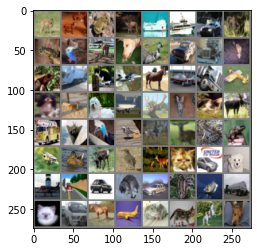

In [16]:
# test the forward pass
# expect output size of [32, num_features]
x, y = next(iter(trainloader))
imshow(torchvision.utils.make_grid(x))
#print(f"x.shape = {x.shape}")
#print(x)
#print(f"y.shape = {y.shape}")
#print(y)

In [17]:
if cuda:
    x = x.cuda()

outputs = net(x)
print(f"x.shape = {x.shape}")
print(f"x_hat.shape = {outputs['x_hat'].shape}")
print(f"z.shape = {outputs['z'].shape}")
print(type(x))
x_hat = outputs['x_hat']
print(type(x_hat))
mm = x.view(-1, width*height*channels)
print(f"mm.shape = {mm.shape}")

x.shape = torch.Size([64, 3, 32, 32])
x_hat.shape = torch.Size([64, 3, 32, 32])
z.shape = torch.Size([64, 256, 2, 2])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
mm.shape = torch.Size([64, 3072])


## Train Network

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 60

train_loss = []
valid_loss = []
counter = 0
for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in trainloader:
        
        # Make a copy, so we do not overwrite the old data
        x_noisy = copy.deepcopy(x)
        x_noisy = add_noise_to_images(x_noisy,0.1,0.1,0.3,0.4)
        
        if cuda:
            x_noisy = x_noisy.cuda()
            x = x.cuda()

        #if counter == 156:
        #    print("STOP")
        outputs = net(x_noisy)
        x_hat = outputs['x_hat']

        # note, target is the original tensor, as we're working with auto-encoders
        #loss = loss_function(x_hat, x.view(-1, width*height*channels)) # TC: Changes this
        loss = loss_function(x_hat, x)  #

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        #counter = counter + 1
        #print("Counter", counter)

    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(testloader))
        
        x_noisy = copy.deepcopy(x)
        x_noisy = add_noise_to_images(x_noisy,0.1,0.1,0.3,0.4)
        
        if cuda:
            x_noisy = x_noisy.cuda()
            x = x.cuda()
        
        outputs = net(x_noisy)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x_hat = outputs['x_hat']
        z = outputs['z'].cpu().numpy()

        #loss = loss_function(x_hat, x.view(batch_size, width*height*channels))
        loss = loss_function(x_hat, x)

        valid_loss.append(loss.item())
    
    if epoch == 0:
        continue

    print("Epoch", epoch, "/", num_epochs)
# live plotting of the trainig curves and representation

Epoch 1 / 60
Epoch 2 / 60
Epoch 3 / 60
Epoch 4 / 60
Epoch 5 / 60
Epoch 6 / 60
Epoch 7 / 60
Epoch 8 / 60
Epoch 9 / 60
Epoch 10 / 60
Epoch 11 / 60
Epoch 12 / 60
Epoch 13 / 60
Epoch 14 / 60
Epoch 15 / 60
Epoch 16 / 60
Epoch 17 / 60
Epoch 18 / 60
Epoch 19 / 60
Epoch 20 / 60
Epoch 21 / 60
Epoch 22 / 60
Epoch 23 / 60
Epoch 24 / 60
Epoch 25 / 60
Epoch 26 / 60
Epoch 27 / 60
Epoch 28 / 60
Epoch 29 / 60
Epoch 30 / 60
Epoch 31 / 60
Epoch 32 / 60
Epoch 33 / 60
Epoch 34 / 60
Epoch 35 / 60
Epoch 36 / 60
Epoch 37 / 60
Epoch 38 / 60
Epoch 39 / 60
Epoch 40 / 60
Epoch 41 / 60
Epoch 42 / 60
Epoch 43 / 60
Epoch 44 / 60
Epoch 45 / 60
Epoch 46 / 60
Epoch 47 / 60
Epoch 48 / 60
Epoch 49 / 60
Epoch 50 / 60
Epoch 51 / 60
Epoch 52 / 60
Epoch 53 / 60
Epoch 54 / 60
Epoch 55 / 60
Epoch 56 / 60
Epoch 57 / 60
Epoch 58 / 60
Epoch 59 / 60


## Plot Errors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


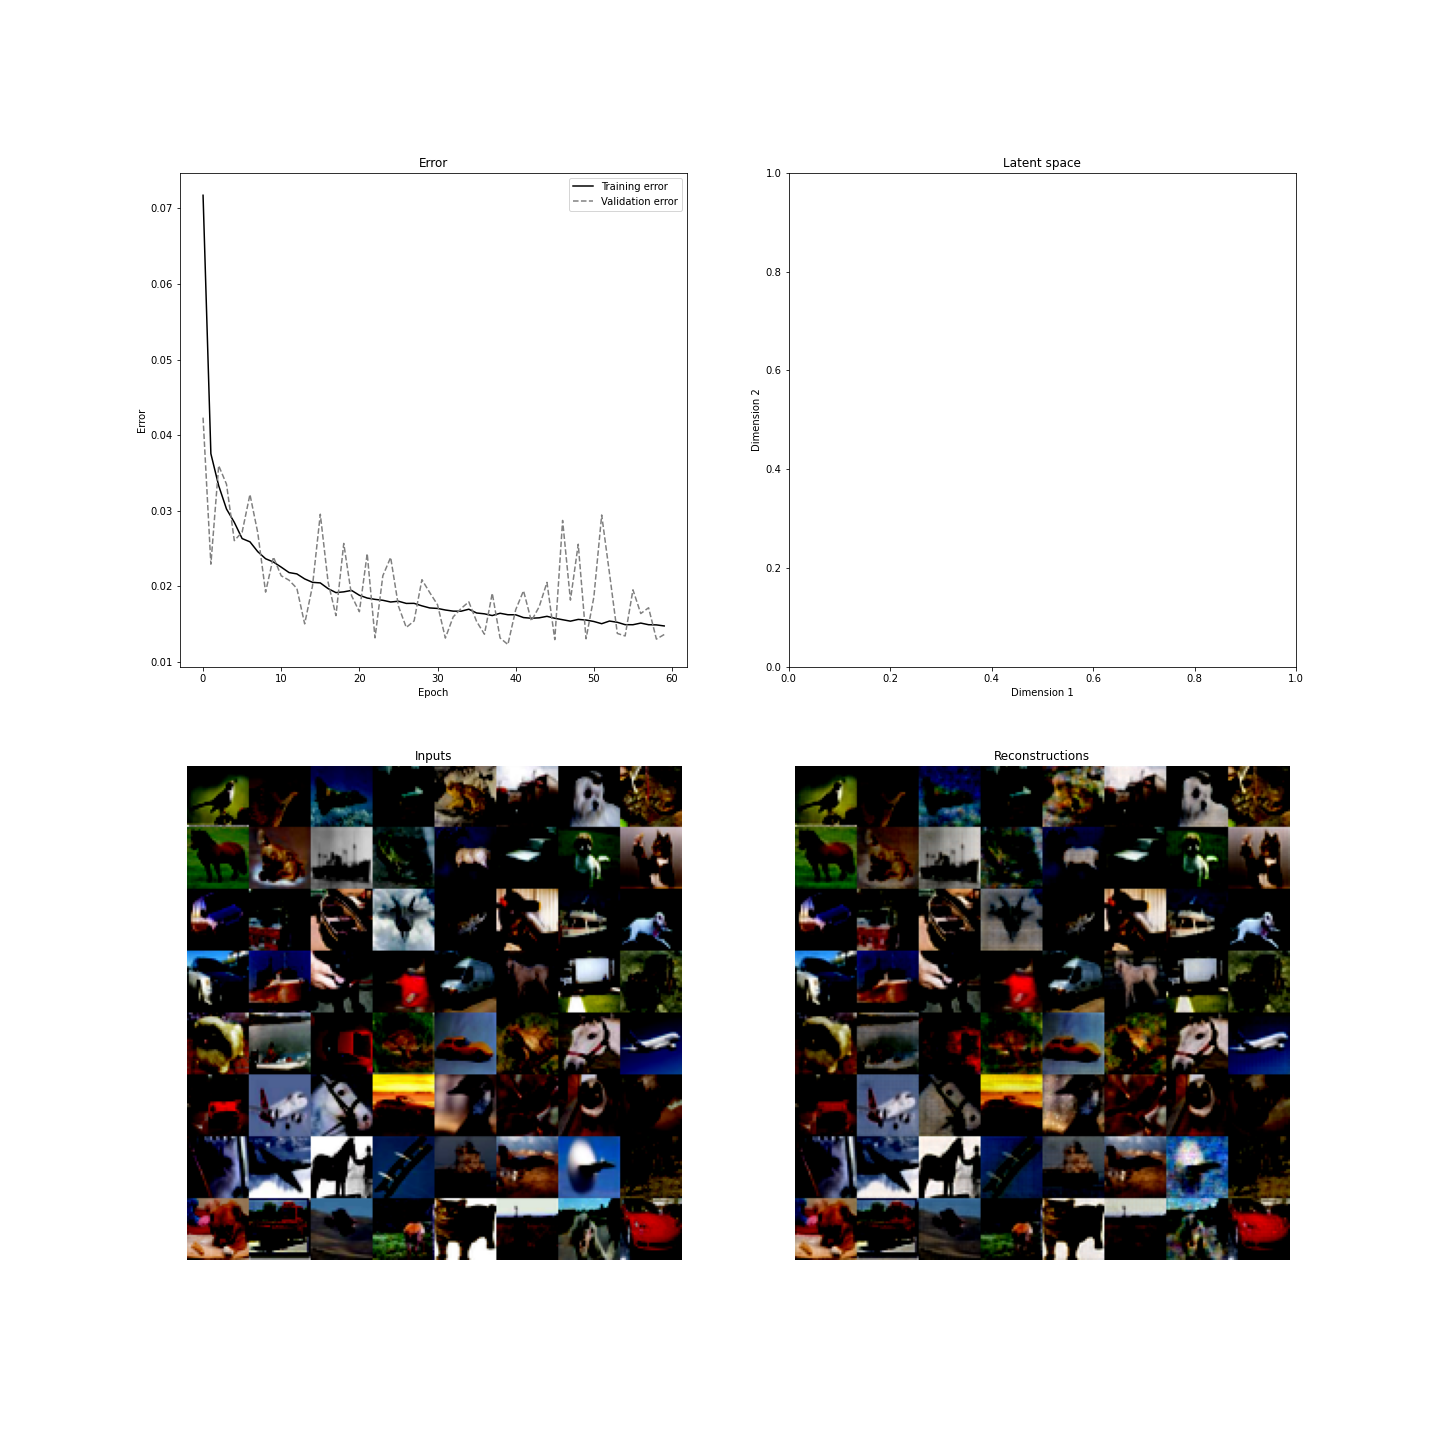

In [19]:
plot_autoencoder_stats(x=x.view(batch_size, width*height*channels),
                        x_hat=x_hat.view(batch_size, width*height*channels),
                        z=z,
                        y=y,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        epoch=epoch,
                        classes=classes,
                        dimensionality_reduction_op=None) 

## Plot Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


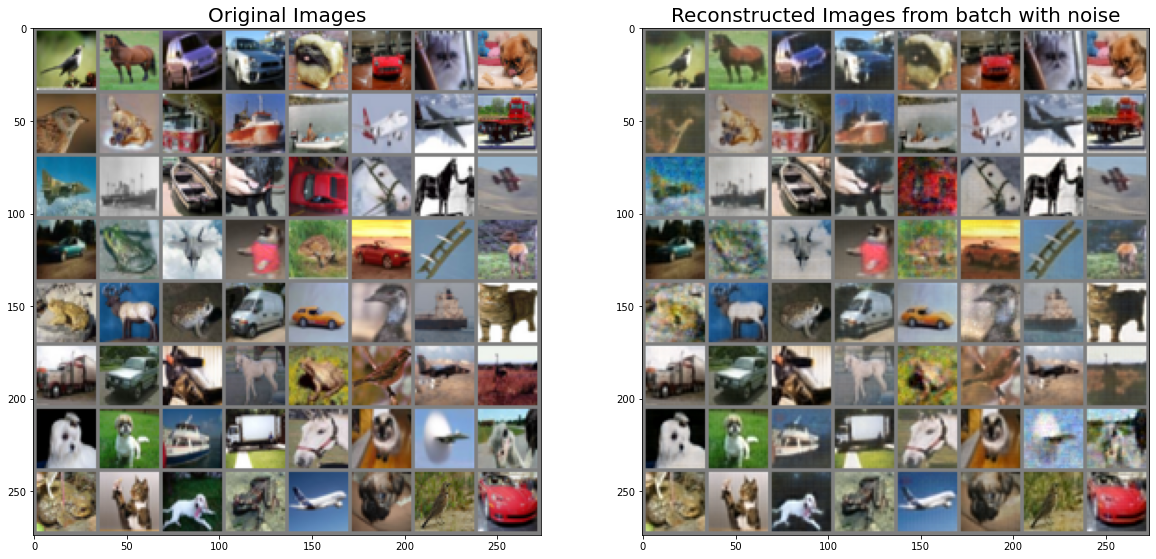

In [20]:
x_hat = x_hat.cpu()

def unnormalize_image(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

f, axarr = plt.subplots(1, 2, figsize=(20, 20))

ax = axarr[0]
x_grid = torchvision.utils.make_grid(x.cpu())
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Original Images", size=20)

ax = axarr[1]
x_hat_grid = torchvision.utils.make_grid(x_hat)
#x_hat_grid = torchvision.utils.make_grid(x_hat_rgb)
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images from batch with noise", size=20)

#imshow(torchvision.utils.make_grid(x.cpu()))


plt.show()

## Gaussian Noise added to input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Images')

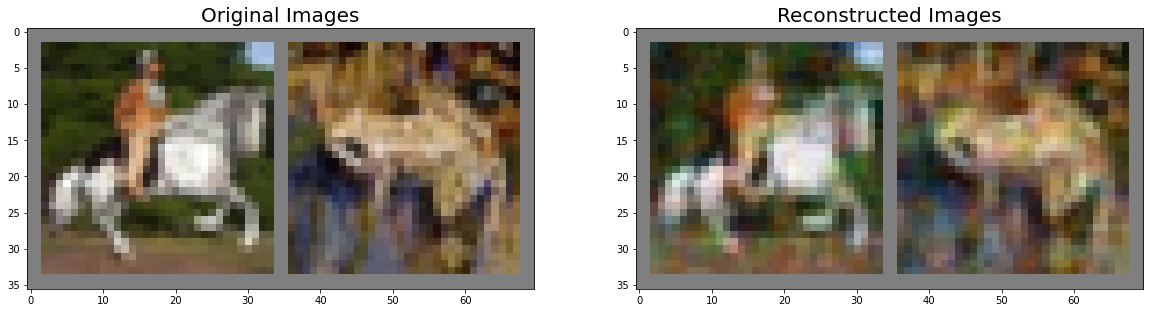

In [21]:
x, y = next(iter(trainloader))
test_img = copy.deepcopy(x)
test_img = add_noise_to_images(test_img,1.,0,0,0)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[0:2].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_hat_grid = torchvision.utils.make_grid(x_hat[0:2].cpu())
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Images')

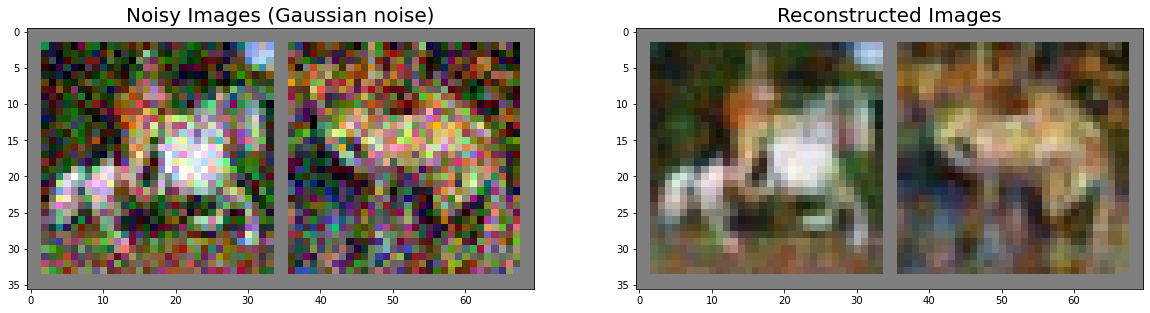

In [22]:
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(test_img[0:2].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Noisy Images (Gaussian noise)", size=20)
ax = axarr[1]
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)

## Salt and Pepper Noise added to input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Images')

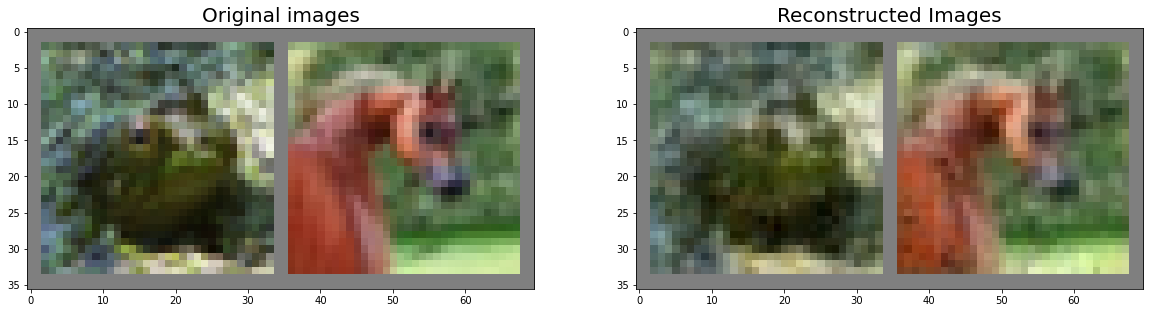

In [23]:
x, y = next(iter(trainloader))
test_img = copy.deepcopy(x)
test_img = add_noise_to_images(test_img,0,1.,0,0)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[0:2].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Original images", size=20)
ax = axarr[1]
x_hat_grid = torchvision.utils.make_grid(x_hat[0:2].cpu())
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Images')

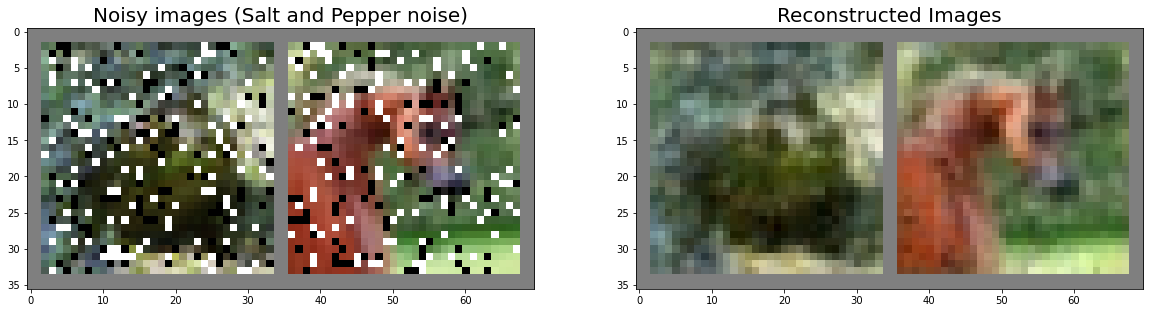

In [24]:
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(test_img[0:2].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Noisy images (Salt and Pepper noise)", size=20)
ax = axarr[1]
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)

## Overexposure added to input images

Text(0.5, 1.0, 'Reconstructed Images')

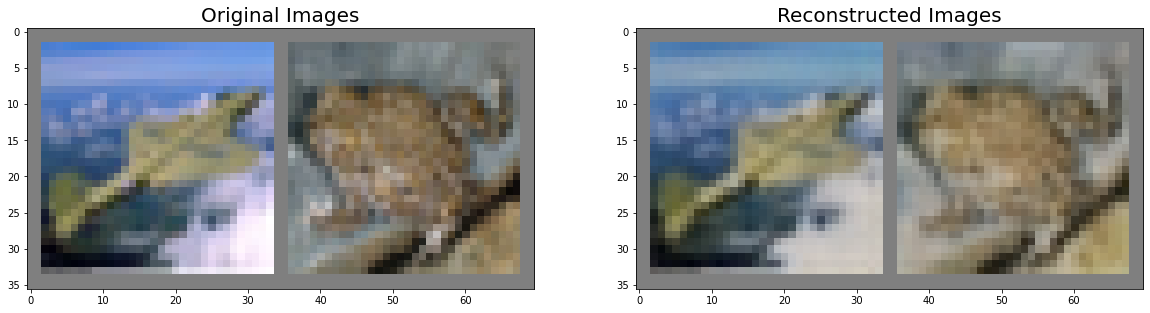

In [25]:
x, y = next(iter(trainloader))
test_img = copy.deepcopy(x)
test_img = add_noise_to_images(test_img,0,0,1.0,0.0)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[0:2].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_hat_grid = torchvision.utils.make_grid(x_hat[0:2].cpu())
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)

Text(0.5, 1.0, 'Reconstructed Images')

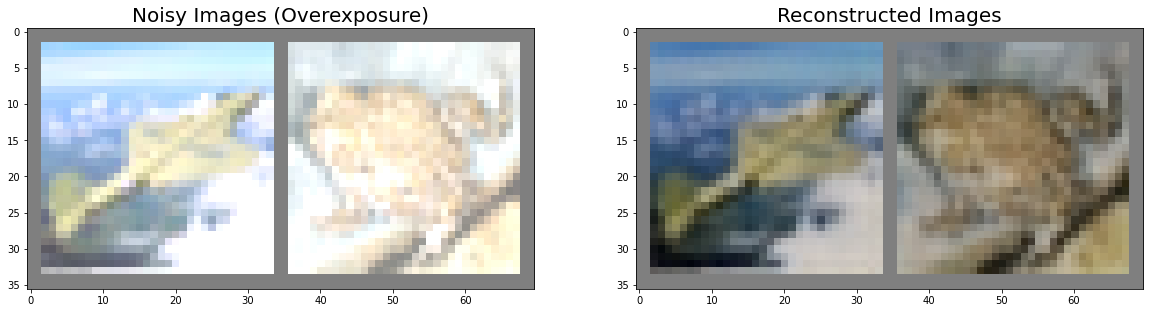

In [26]:
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(test_img[0:2].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Noisy Images (Overexposure)", size=20)
ax = axarr[1]
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)

## Underexposure added to input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Images')

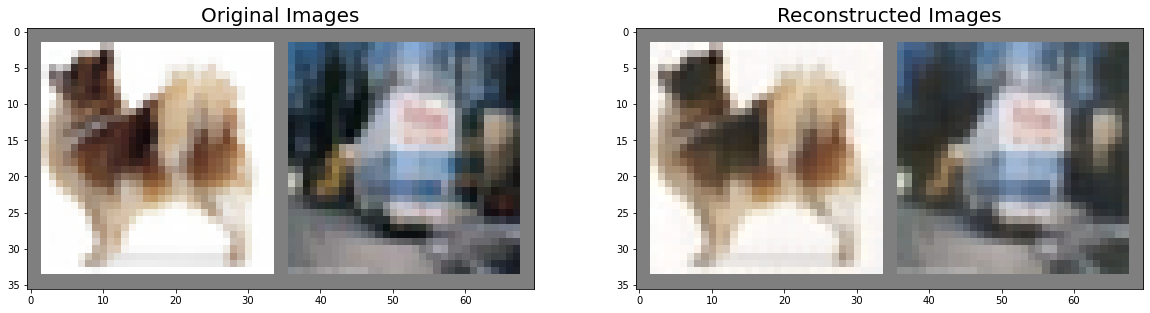

In [27]:
x, y = next(iter(trainloader))
test_img = copy.deepcopy(x)
test_img = add_noise_to_images(test_img,0,0,0.0,1.0)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[0:2].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_hat_grid = torchvision.utils.make_grid(x_hat[0:2].cpu())
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Images')

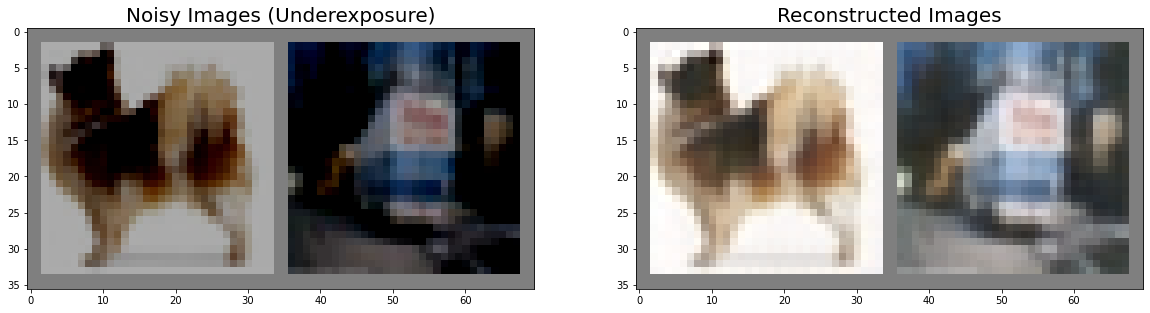

In [28]:
f, axarr = plt.subplots(1, 2, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(test_img[0:2].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Noisy Images (Underexposure)", size=20)
ax = axarr[1]
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)